In [11]:
import os
import time
import datetime
import pandas as pd
import seaborn as sns
import numpy as np
import random
import matplotlib.pyplot as plt

# wandb for tracking experiment and sweeping hyperparamters
import wandb
# pyyaml (yaml) :: parses configuration files (YAML files)
# see https://www.cloudbees.com/blog/yaml-tutorial-everything-you-need-get-started for more information on YAML files
import yaml 

# huggingface :: datasets : dataset-handling libraries from huggingface
from datasets import load_dataset
#from datasets.filesystems import S3FileSystem # for S3 interactions

# huggingface :: transformers : transformer, trainer and tokenizer objects for the actual training
import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler

from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config, AutoTokenizer, AutoModelForCausalLM, DataCollatorForLanguageModeling, Trainer, TrainingArguments
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling

In [12]:
# nltk punkt sentence tokenizer, divides text into a list of sentences
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [13]:
!nvidia-smi

Tue Feb 21 18:08:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   26C    P8    14W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [36]:
path_to_config = "../configs/gpt2-refl-21-feb-2023.yaml"

In [37]:
path_to_config = "../configs/gpt2-refl-19-feb-2023.yaml"
# open yaml config as a strema and load into config_dict
with open(path_to_config, "r") as stream:
    try:
        config_dict = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print("Configuration load failed!")
        print(exc)

In [16]:
df = pd.read_csv(config_dict["data_train_path"])
df_val = pd.read_csv(config_dict["data_validation_path"])

In [17]:
df.dropna(inplace=True)  # drop NA values
triplets = df.triplet.copy()  # copy over triplets

In [18]:
val_triplets = df_val.triplet.copy()  # validation triplets

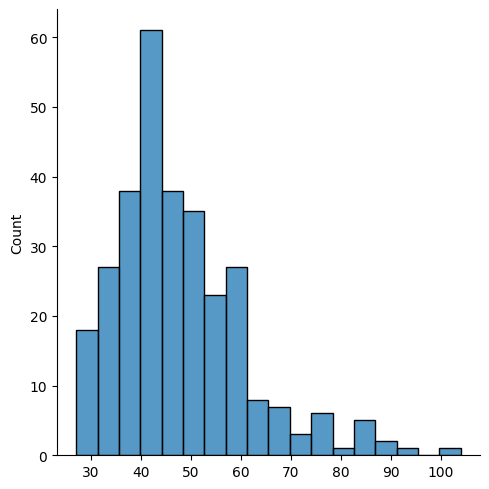

In [19]:
# how long is our training data?
doc_lengths = []
for triplet in triplets:
    tokens = nltk.word_tokenize(triplet)
    doc_lengths.append(len(tokens))
doc_lengths = np.asarray(doc_lengths)
sns.displot(doc_lengths)

In [20]:
np.average(doc_lengths)
# on average, we have ~47.5 tokens per entry, a good thing for GPT2 embedding size of 768 in gpt-small

47.57807308970099

In [38]:
# all the below set the corresponding values from the configuration file config.yaml:
model_name = config_dict["model_name"]
pretrained = config_dict["pretrained"]
data_train_path = config_dict["data_train_path"]
data_validation_path = config_dict["data_validation_path"]



output_data_dir = config_dict["output_data_dir"] + "/"
output_model_dir = config_dict["output_model_dir"] + "/"

hyperparameters = config_dict["training_settings"]["hyperparameters"]
hyperparameters["learning_rate"] = float(hyperparameters["learning_rate"])
hyperparameters["weight_decay"] = float(hyperparameters["weight_decay"])

deepspeed_config = config_dict["training_settings"]["deepspeed_settings"]

learning_rate = hyperparameters['learning_rate']
epsilon = float(hyperparameters['epsilon'])  # epsilon must be a float, not str
epochs = hyperparameters['epochs']
warmup_steps = float(hyperparameters['warmup_steps'])
sample_every = float(hyperparameters['sample_every'])
batch_size = int(hyperparameters['batch_size'])

In [39]:
# load gpt-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained(model_name, bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [40]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


In [41]:
# amount of examples passed through model before a backwards pass
batch_size = hyperparameters['batch_size']

In [42]:
class GPT2Dataset(Dataset):
    # Inherits Dataset from PyTorch, a data primitive which
    # stores samples and corresponding labels
    # custom Dataset needs init, len, and getitem
    # init runs once when instantiating Dataset object
    def __init__(self, txt_list, tokenzier, gpt2_type='gpt2', max_length=768):
        self.tokenizer = tokenizer,
        self.input_ids = []
        self.attn_masks = []
        
        # for each text list, encode it using tokenizer then unpacl encodings dict into:
        # input_ids: numerical representations of our tokens
        # attn_masks: indicates which tokens should be attended to (and which are pads)
        for txt in txt_list:
            # tokenize the txt with a custom start and end token
            # encodings dict contains both our token input ids and attention mask
            # truncation will clip sentences that are too long
            # padding adds pad tokens until we reach max input sentence length 768
            encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")
            
            self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
            self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    # overrides len() to returns the number of samples in our dataset
    def __len__(self):
        return len(self.input_ids)
    # loads and returns a sample from dataset at given index idx
    # sometimes we need to do type swapping in getitem, but not here
    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx]
            
        
train_dataset = GPT2Dataset(triplets, tokenizer, max_length=768)
val_dataset = GPT2Dataset(val_triplets, tokenizer, max_length=768)

In [43]:
train_dataset = GPT2Dataset(triplets, tokenizer, max_length=768)
val_dataset = GPT2Dataset(val_triplets, tokenizer, max_length=768)

In [44]:
print(f"{len(train_dataset)} Training Samples")
print(f"{len(val_dataset)} Validation Samples")

301 Training Samples
34 Validation Samples


In [45]:
# Create DataLoader for training and validation datasets
# PyTorch DataLoaders wrap iterable around a Dataset to access samples easily
# We typically pass in minibatches and reshuffle data at epochs to reduce overfitting
# DataLoaders leverage python's multiprocessing to speed up data retrieval

# take training samples in random order
train_dataloader = DataLoader(train_dataset,
                              sampler=RandomSampler(train_dataset),
                              batch_size=batch_size)

# For validation, the order doesn't matter, so we read sequentially
validation_dataloader = DataLoader(val_dataset,
                                   sampler=SequentialSampler(val_dataset),
                                   batch_size=batch_size)

In [46]:
# config to instantiate model
configuration = GPT2Config.from_pretrained(model_name, output_hidden_states=False)


In [47]:
# instantiate model
model = GPT2LMHeadModel.from_pretrained(model_name, config=configuration)


In [48]:
# resize token embeddings for our custom tokens (e.g. bos_token)
model.resize_token_embeddings(len(tokenizer))

Embedding(50259, 768)

In [49]:
device = torch.device("cuda")

In [50]:
# sends model to current device - in this case CUDA
model.cuda()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

In [51]:
# Set the seed value
seed_val = int(hyperparameters['seed'])
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [35]:
wandb.init(
  project="gpt2-sweep-reflector",
  notes="Trying to sweep gpt2 reflector",
  tags=["gpt2", "reflector", "sweep"],
)

wandb: Currently logged in as: andrewbrown. Use `wandb login --relogin` to force relogin
time="2023-02-21T18:14:05Z" level=fatal msg="Failed to discover neuron devices" error="Unable to read device information from the driver. Make sure aws-neuron-dkms is installed and the neuron driver is accessible."


In [52]:
hyperparameters

{'find_hyperparams_automatically': False,
 'num_trials': 10,
 'fp16': True,
 'deepspeed': True,
 'grad_accumulation_steps': 2,
 'eval_batch_size': 1,
 'learning_rate': 0.0002,
 'epochs': 20,
 'warmup_steps': '1e2',
 'epsilon': '3e-8',
 'batch_size': 1,
 'sample_every': 100,
 'seed': 42,
 'eval_steps': 10,
 'weight_decay': 0.01}

In [53]:
wandb.config.update(config_dict)

In [54]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

/home/ubuntu/anaconda3/envs/torch_p37/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [55]:
# Total num training steps is [num batches] x [num epochs]
# (not the same number as num training sample)
total_steps = len(train_dataloader) * epochs

In [56]:
# Create learning rate scheduler
# we schedule learning rate using 
# optimzer, num_warmup steps, and num_training steps
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=warmup_steps,
                                            num_training_steps=total_steps)

In [57]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [103]:
sweep_config = {
    'method': 'grid',
    'name': 'gpt2-xl Grid Sweep',
    'metric': {'goal': 'minimize', 'name': 'train_acc'},
    
    # parameters is the nested dictionary of hyperparameters we are sweeping
    'parameters': 
    {
        'batch_size': {'values': [1]},
        'epochs': {'values': [5, 10, 15]},
        'learning_rate': {
        # a flat distribution between 0 and 0.1
        'distribution': 'uniform',
        'min': 0,
        'max': 0.1},
     }
}

In [104]:
sweep_id = wandb.sweep(sweep_config, project="gpt2-sweep-reflector")

Create sweep with ID: 3n2rw2r6
Sweep URL: https://wandb.ai/andrewbrown/gpt2-sweep-reflector/sweeps/3n2rw2r6


In [105]:
wandb.init(
  project="gpt2-sweep-reflector",
  config=config_dict,
  notes="Trying to sweep gpt2 reflector",
  tags=["gpt2", "reflector", "sweep"],
)

time="2023-02-20T04:23:01Z" level=fatal msg="Failed to discover neuron devices" error="Unable to read device information from the driver. Make sure aws-neuron-dkms is installed and the neuron driver is accessible."


In [56]:
class GPT2Dataset(Dataset):
    # Inherits Dataset from PyTorch, a data primitive which
    # stores samples and corresponding labels
    # custom Dataset needs init, len, and getitem
    # init runs once when instantiating Dataset object
    def __init__(self, txt_list, tokenzier, gpt2_type='gpt2', max_length=768):
        self.tokenizer = tokenizer,
        self.input_ids = []
        self.attn_masks = []
        
        # for each text list, encode it using tokenizer then unpacl encodings dict into:
        # input_ids: numerical representations of our tokens
        # attn_masks: indicates which tokens should be attended to (and which are pads)
        for txt in txt_list:
            # tokenize the txt with a custom start and end token
            # encodings dict contains both our token input ids and attention mask
            # truncation will clip sentences that are too long
            # padding adds pad tokens until we reach max input sentence length 768
            encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")
            
            self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
            self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    # overrides len() to returns the number of samples in our dataset
    def __len__(self):
        return len(self.input_ids)
    # loads and returns a sample from dataset at given index idx
    # sometimes we need to do type swapping in getitem, but not here
    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx]
            
def build_dataset(triplets, tokenizer, batch_size, max_length=768):
    dataset = GPT2Dataset(triplets, tokenizer, max_length=768)
    return DataLoader(dataset, sampler=RandomSampler(dataset), batch_size=batch_size)

In [57]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
def build_optimizer(model, learning_rate, epsilon):
    return AdamW(model.parameters(), lr = learning_rate, eps = epsilon)

In [110]:
def train():
    path_to_config = "../configs/gpt2-refl-19-feb-2023.yaml"
    # open yaml config as a strema and load into config_dict
    with open(path_to_config, "r") as stream:
        try:
            config_dict = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print("Configuration load failed!")
            print(exc)
    # Initialize a new wandb run
    with wandb.init(project="gpt2-sweep-reflector", config=config_dict, notes="Trying to sweep gpt2 reflector",tags=["gpt2", "reflector", "sweep"]):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config
        batch_size = int(config.training_settings['hyperparameters']['batch_size'])
        learning_rate = float(config.training_settings['hyperparameters']['learning_rate'])
        epsilon = float(config.training_settings['hyperparameters']['epsilon'])
        epochs = int(config.training_settings['hyperparameters']['epochs'])

        loader = build_dataset(triplets, tokenizer, batch_size, max_length=768)
        # not varying model architecture
        #network = build_network(config.fc_layer_size, config.dropout)
        optimizer = build_optimizer(model, learning_rate, epsilon)
        for epoch in range(epochs):
            avg_loss = train_epoch(model, loader, optimizer)
            wandb.log({"loss": avg_loss, "epoch": epoch})    

In [111]:
wandb.agent(sweep_id, train, count=5)

wandb: Agent Starting Run: wnyy3e9u with config:
wandb: 	batch_size: 1
wandb: 	epochs: 5
wandb: 	learning_rate: 0.03908492653710586
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
time="2023-02-20T04:27:18Z" level=fatal msg="Failed to discover neuron devices" error="Unable to read device information from the driver. Make sure aws-neuron-dkms is installed and the neuron driver is accessible."


/home/ubuntu/anaconda3/envs/torch_p37/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:15 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:18 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:20 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:21 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:20 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:21 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:21 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:16 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:14 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:15 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:16 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:19 ---
---Training...---
---Done Training Epoch

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,19
loss,0.01397


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rz26rorc with config:
wandb: 	batch_size: 1
wandb: 	epochs: 5
wandb: 	learning_rate: 0.002138355664066671
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
time="2023-02-20T04:53:23Z" level=fatal msg="Failed to discover neuron devices" error="Unable to read device information from the driver. Make sure aws-neuron-dkms is installed and the neuron driver is accessible."


/home/ubuntu/anaconda3/envs/torch_p37/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:15 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:15 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:16 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:15 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:16 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:17 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:20 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:22 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:19 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:17 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:17 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:17 ---
---Training...---
---Done Training Epoch

wandb: ERROR Summary data exceeds maximum size of 10.4MB. Dropping it.


---Done Training Epoch!---
---Training epoch took 0:01:19 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:19 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:17 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:17 ---


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,19
loss,0.0089


wandb: Agent Starting Run: mpxfhf28 with config:
wandb: 	batch_size: 1
wandb: 	epochs: 5
wandb: 	learning_rate: 0.07716695180056597
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
time="2023-02-20T05:19:24Z" level=fatal msg="Failed to discover neuron devices" error="Unable to read device information from the driver. Make sure aws-neuron-dkms is installed and the neuron driver is accessible."


/home/ubuntu/anaconda3/envs/torch_p37/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:17 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:17 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:18 ---
---Training...---


wandb: ERROR Summary data exceeds maximum size of 10.4MB. Dropping it.


---Done Training Epoch!---
---Training epoch took 0:01:19 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:21 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:23 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:25 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:24 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:22 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:18 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:18 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:18 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:19 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:18 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:18 ---
---Training...---
---Done Training Epoch!---
---Training e

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,▅██▅▂▄▇▅▅▄▄▂▁▁▄▂▃▅▃▃
epoch,19
loss,0.0112


wandb: Agent Starting Run: 4kmtoa5b with config:
wandb: 	batch_size: 1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.016577142569395877
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
time="2023-02-20T05:46:09Z" level=fatal msg="Failed to discover neuron devices" error="Unable to read device information from the driver. Make sure aws-neuron-dkms is installed and the neuron driver is accessible."


/home/ubuntu/anaconda3/envs/torch_p37/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:20 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:23 ---
---Training...---


wandb: ERROR Summary data exceeds maximum size of 10.4MB. Dropping it.


---Done Training Epoch!---
---Training epoch took 0:01:26 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:26 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:26 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:26 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:26 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:21 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:19 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:19 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:20 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:22 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:25 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:26 ---
---Training...---
---Done Training Epoch!---
---Training e

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,▇▆▃▂▅▅▇▅▂▁▂▂▂█▄▂▃▁▃▃
epoch,19
loss,0.01033


wandb: Agent Starting Run: zqi6lxsu with config:
wandb: 	batch_size: 1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.04532143387048465
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
time="2023-02-20T06:14:40Z" level=fatal msg="Failed to discover neuron devices" error="Unable to read device information from the driver. Make sure aws-neuron-dkms is installed and the neuron driver is accessible."


/home/ubuntu/anaconda3/envs/torch_p37/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:22 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:19 ---
---Training...---


wandb: ERROR Summary data exceeds maximum size of 10.4MB. Dropping it.


---Done Training Epoch!---
---Training epoch took 0:01:20 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:21 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:23 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:27 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:28 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:27 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:27 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:28 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:27 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:27 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:27 ---
---Training...---
---Done Training Epoch!---
---Training epoch took 0:01:27 ---
---Training...---
---Done Training Epoch!---
---Training e

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,▆▃▇█▅▂▂▃▄▂▄▄▂▄▃▃▂▄▁▃
epoch,19
loss,0.00989


In [45]:
def train_epoch(model, train_dataloader, optimizer):
    training_stats = []

    model = model.to(device)

    """
    Training for one epoch
    """
    wandb.watch(model)
    print("---Training...---")

    # start epoch timer
    t0 = time.time()

    total_train_loss = 0

    # sets model into train mode, not actual backprop
    # dropout and batchnorm behave differently
    # opposite of model.eval() for inference mode
    model.train()

    for step, batch in enumerate(train_dataloader):
        # grab input tokens, labels, and masks
        input_tokens = batch[0].to(device)
        # in this case, we're generating text,
        # so label tokens are the input tokens shifted
        label_tokens = batch[0].to(device)
        attn_masks = batch[1].to(device)

        # clear any gradients from model tensors
        # prevents any gradient accumulation
        model.zero_grad()

        # forward pass
        outputs = model(input_tokens,
                        labels=label_tokens,
                        attention_mask=attn_masks,
                        token_type_ids=None
                       )

        # grab loss from outputs
        loss = outputs[0]

        batch_loss = loss.item()  # detach from device with item
        total_train_loss += batch_loss

        # backpropagation step
        # computes dloss/dx for every parameter x which has requires_grad=True.
        # updates gradient values
        # x.grad += dloss/dx
        loss.backward()

        # step optimizer
        # updates the value of x using the gradient x.grad
        # x += -lr * x.grad
        optimizer.step()

        # step scheduler
        # tells scheduler to increase learning rate
        # using our warmup steps
        scheduler.step()

    print("---Done Training Epoch!---")
    # measure how long the epoch took
    training_time = format_time(time.time() - t0)

    print(f"---Training epoch took {training_time} ---")
    # calculate average loss over all batches
    return total_train_loss / len(train_dataloader)

In [ ]:
def validate_one_epoch():
    """
    Validation
    """
    print("---Running Validation...---")
    
    # start batch timer
    t0 = time.time()
    
    # set model to inference mode
    model.eval()
    
    total_eval_loss = 0
    nb_eval_steps = 0
    
    # evaluate data for one epoch
    for batch in validation_dataloader:
        # grab input tokens, labels, and masks
        input_tokens = batch[0].to(device)
        # in this case, we're generating text,
        # so label tokens are the input tokens shifted
        label_tokens = batch[0].to(device)
        attn_masks = batch[1].to(device)
        
        # freeze gradients
        with torch.no_grad():
            outputs = model(input_tokens,
                            attention_mask=attn_masks,
                            labels=label_tokens)
            
            loss = outputs[0]
        
        batch_loss = loss.item()
        total_eval_loss += batch_loss
        
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)
    
    print(f"Validation Loss: {avg_val_loss}")
    print(f"Validation took: {validation_time}")
    
    # save all training statistics from the epoch
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Validation Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        })
    # log training data to wandb as well
    wandb.log({
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Validation Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        })
    


In [59]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Validation Loss,Training Time,Validation Time
epoch,,,,
1,0.05,0.09,0:01:08,0:00:02
2,0.05,0.09,0:01:10,0:00:03
3,0.05,0.09,0:01:13,0:00:03
4,0.05,0.09,0:01:21,0:00:03
5,0.05,0.09,0:01:23,0:00:03


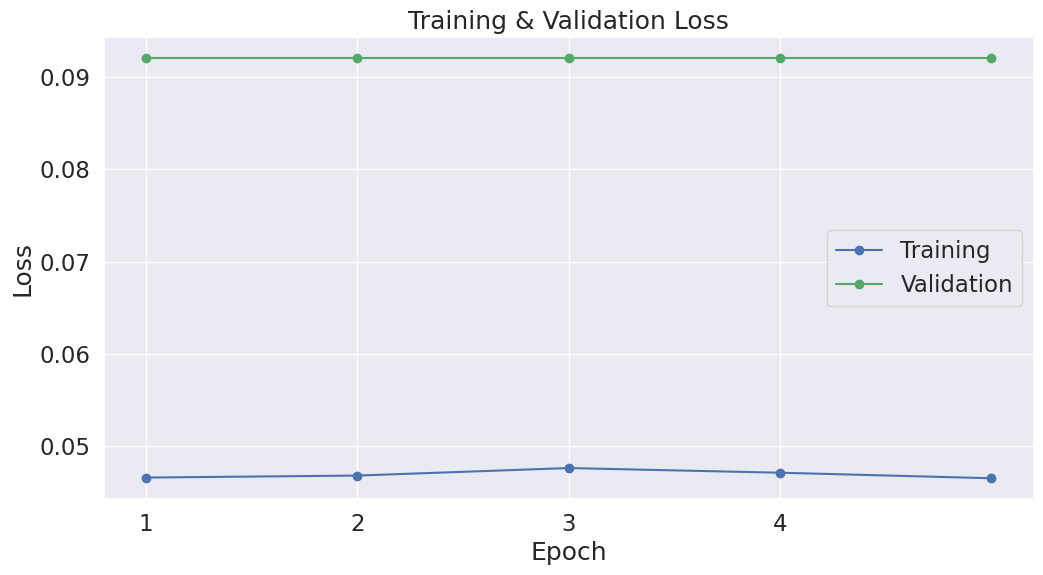

In [63]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Validation Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [32]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

In [40]:
# saving and loading the finetuned model
output_dir = '../../Output/model/gpt-feb6/'
tokenizer_dir = '../../Output/model/gpt-tokenizer-feb6/'

# create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# create output directory if needed
if not os.path.exists(tokenizer_dir):
    os.makedirs(tokenizer_dir)
    
    
print(f"Saving model to {output_dir}")

Saving model to ../../Output/model/gpt-feb5/


In [41]:
# Save trained model, configuration and tokenizer
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(tokenizer_dir)

('../../Output/model/gpt-tokenizer-feb5/tokenizer_config.json',
 '../../Output/model/gpt-tokenizer-feb5/special_tokens_map.json',
 '../../Output/model/gpt-tokenizer-feb5/vocab.json',
 '../../Output/model/gpt-tokenizer-feb5/merges.txt',
 '../../Output/model/gpt-tokenizer-feb5/added_tokens.json')

In [43]:
# save training arguments with trained model
torch.save(model.state_dict(), os.path.join(output_dir, 'training_args.bin'))

In [ ]:
# # Load a trained model and vocabulary that you have fine-tuned
model = GPT2LMHeadModel.from_pretrained(output_dir)
tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
model.to(device)